In [1]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import models
from IPython.display import HTML
import time

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

# Seed() method used to initialise a random number generator
# The random number generator requires a number to start with (seed value) to be able to generate a random number
# If you the same seed value you'll get the same set of random numbers
random.seed(manualSeed)

# Sets the seed for randomly generating values with pytorch
# TODO where is this used
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
### Dataroots for the different datasets
home_dir = "/home/a/Projects/dcgans-2d-pytorch/" # on machine
ext_dir = "/media/a/Seagate Basic/home/a/Projects/dggan-pytorch-2d-images/" # on external hard drive


## Celeba Dataset: 
# dataset_name = "celeba"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/celeba/"

## Scan The World main dataset:
# dataset_name = "scan-the-world-main-images"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/scan-the-world-main-images/"

## 2D Scan The World busts dataset: 
# dataset_name = "scan-the-world-busts-images"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/scan-the-world-busts-images/"

## Mixed god dataset:
# dataset_name = "mixed-gods"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/mixed-gods/"

# Sanitised mixed god dataset
# dataset_name = "sanitised-mixed-gods"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/sanitised-mixed-gods/"

# Sanitised mixed god dataset
# dataset_name = "sanitised-mixed-gods-scan-the-world"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/sanitised-mixed-gods-scan-the-world/"

# Unsanitised full dataset
# dataset_name = "unsanitised-full-dataset"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/all-scan-the-world-images/"

# # Facial recognition full dataset
# dataset_name = "facerecog-recog-full-dataset"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/facerecog-all-scan-the-world/"

# Tags classifier - busts
# dataset_name = "tags-classifier-fullbody"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/busts-tags-classifier/"
    
# Tags classifier - fullbody
# dataset_name = "tags-classifier-fullbody-label-smoothing-flip-d-labels"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/fullbody-tags-classifier/"

# Fully manually sanitised fullbody dataset
dataset_name = "fully-manually-sanitised-fullbody-dataset-flip-d-occassionally"
dataroot = ext_dir + "data/fully-manually-sanitised-fullbody-dataset/"


workers = 2 
batch_size = 128
image_size = 64 
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [3]:
# Make output directory
results_dir = "results_" + dataset_name + "_epochs_" + str(num_epochs) + "_" + time.strftime("%Y%m%d-%H%M%S")
path = os.path.join(home_dir + "outputs", results_dir)
os.mkdir(path)

Size of the dataset:  32490


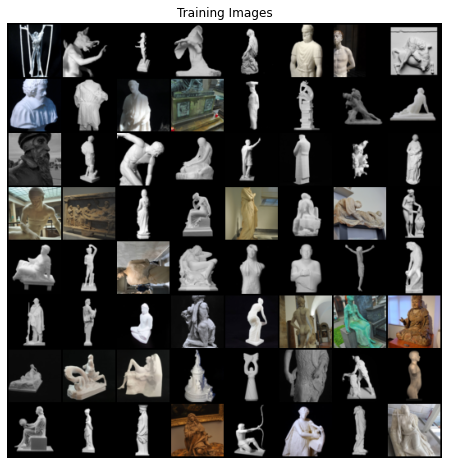

In [4]:
# Create dataset by standardising and normalizing the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader - python iterable over the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

dataset_size = len(dataloader.dataset)
print("Size of the dataset: ", dataset_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images before any training has begun
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4          
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            
            
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
        
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# randomly flip some labels
def flip_labels_randomly(label, percentage):
    # number of labels to flip
    num_label_flip = int(percentage * label.shape[0])
    # choose labels to flip
    label_flip = np.random.choice([i for i in range(label.shape[0])], size=num_label_flip)
    # invert the labels in place
    label[label_flip] = 1 - label[label_flip]
    return label

In [12]:
import csv
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_fake_losses = []
D_real_losses = []
D_x_acc = []
D_G_z1_acc = []
D_G_z2_acc = []
iters = 0

wtr = csv.writer(open (os.path.join(path,'training_stats.csv'), 'w', newline=''))
wtr.writerow(["Current Epoch", "Total number of epochs", "Iteration", "Batch_size", "D_losses", "D_fake_losses", "D_real_losses", "G_losses", "D_accuracy", "D_G_z1_accurancy", "D_G_z2_accuracy"])
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = flip_labels_randomly(label, 0.05)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        label = flip_labels_randomly(label, 0.05)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output - note this is loss on fake 
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_D_fake: %.4f\tLoss_D_real: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errD_fake.item(), errD_real.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            wtr.writerow([epoch, num_epochs, i, len(dataloader), errD.item(), errD_fake.item(), errD_real.item(), errG.item(), D_x, D_G_z1, D_G_z2])

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_fake_losses.append(errD_fake.item())
        D_real_losses.append(errD_real.item())
        D_x_acc.append(D_x)
        D_G_z1_acc.append(D_G_z1)
        D_G_z2_acc.append(D_G_z2)
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/254]	Loss_D: 1.7985	Loss_D_fake: 1.0585	Loss_D_real: 0.7400	Loss_G: 4.3356	D(x): 0.5333	D(G(z)): 0.6054 / 0.0204
[0/100][50/254]	Loss_D: 1.3177	Loss_D_fake: 0.5619	Loss_D_real: 0.7559	Loss_G: 16.6971	D(x): 0.6349	D(G(z)): 0.0000 / 0.0000
[0/100][100/254]	Loss_D: 0.5681	Loss_D_fake: 0.2584	Loss_D_real: 0.3097	Loss_G: 2.5783	D(x): 0.8166	D(G(z)): 0.1520 / 0.1037
[0/100][150/254]	Loss_D: 0.7157	Loss_D_fake: 0.2099	Loss_D_real: 0.5058	Loss_G: 3.1601	D(x): 0.6728	D(G(z)): 0.0462 / 0.0654
[0/100][200/254]	Loss_D: 0.5026	Loss_D_fake: 0.2478	Loss_D_real: 0.2548	Loss_G: 2.7225	D(x): 0.9036	D(G(z)): 0.1473 / 0.0804
[0/100][250/254]	Loss_D: 0.6648	Loss_D_fake: 0.2026	Loss_D_real: 0.4622	Loss_G: 1.5920	D(x): 0.7151	D(G(z)): 0.1222 / 0.2648
[1/100][0/254]	Loss_D: 0.7707	Loss_D_fake: 0.2119	Loss_D_real: 0.5588	Loss_G: 2.1833	D(x): 0.6360	D(G(z)): 0.0811 / 0.1304
[1/100][50/254]	Loss_D: 0.5902	Loss_D_fake: 0.2670	Loss_D_real: 0.3232	Loss_G: 3.5186	D(x): 0.8231	D(G(

[11/100][0/254]	Loss_D: 0.8742	Loss_D_fake: 0.4126	Loss_D_real: 0.4616	Loss_G: 1.6369	D(x): 0.6660	D(G(z)): 0.2852 / 0.2177
[11/100][50/254]	Loss_D: 0.8930	Loss_D_fake: 0.4880	Loss_D_real: 0.4050	Loss_G: 1.8994	D(x): 0.7101	D(G(z)): 0.3588 / 0.1748
[11/100][100/254]	Loss_D: 0.8961	Loss_D_fake: 0.3651	Loss_D_real: 0.5310	Loss_G: 1.3860	D(x): 0.6245	D(G(z)): 0.2562 / 0.2790
[11/100][150/254]	Loss_D: 0.9378	Loss_D_fake: 0.4059	Loss_D_real: 0.5319	Loss_G: 1.5564	D(x): 0.6299	D(G(z)): 0.2863 / 0.2443
[11/100][200/254]	Loss_D: 1.1196	Loss_D_fake: 0.2905	Loss_D_real: 0.8290	Loss_G: 0.8359	D(x): 0.4548	D(G(z)): 0.1714 / 0.4611
[11/100][250/254]	Loss_D: 0.9279	Loss_D_fake: 0.4182	Loss_D_real: 0.5097	Loss_G: 1.4792	D(x): 0.6414	D(G(z)): 0.3060 / 0.2567
[12/100][0/254]	Loss_D: 1.1159	Loss_D_fake: 0.3851	Loss_D_real: 0.7308	Loss_G: 1.0165	D(x): 0.5119	D(G(z)): 0.2843 / 0.3946
[12/100][50/254]	Loss_D: 1.7892	Loss_D_fake: 0.2186	Loss_D_real: 1.5705	Loss_G: 0.4344	D(x): 0.2265	D(G(z)): 0.0870 / 0.663

[22/100][0/254]	Loss_D: 0.8825	Loss_D_fake: 0.3586	Loss_D_real: 0.5239	Loss_G: 1.5535	D(x): 0.6486	D(G(z)): 0.2410 / 0.2480
[22/100][50/254]	Loss_D: 0.9052	Loss_D_fake: 0.5396	Loss_D_real: 0.3656	Loss_G: 2.1486	D(x): 0.7415	D(G(z)): 0.3710 / 0.1432
[22/100][100/254]	Loss_D: 0.9974	Loss_D_fake: 0.4579	Loss_D_real: 0.5394	Loss_G: 1.5652	D(x): 0.6430	D(G(z)): 0.3173 / 0.2461
[22/100][150/254]	Loss_D: 0.9489	Loss_D_fake: 0.3087	Loss_D_real: 0.6401	Loss_G: 1.2185	D(x): 0.5589	D(G(z)): 0.1758 / 0.3213
[22/100][200/254]	Loss_D: 0.9794	Loss_D_fake: 0.6424	Loss_D_real: 0.3370	Loss_G: 2.3155	D(x): 0.7579	D(G(z)): 0.4263 / 0.1291
[22/100][250/254]	Loss_D: 0.9317	Loss_D_fake: 0.5079	Loss_D_real: 0.4238	Loss_G: 1.7562	D(x): 0.6953	D(G(z)): 0.3489 / 0.2037
[23/100][0/254]	Loss_D: 1.0638	Loss_D_fake: 0.4073	Loss_D_real: 0.6564	Loss_G: 1.4639	D(x): 0.5757	D(G(z)): 0.2980 / 0.2666
[23/100][50/254]	Loss_D: 0.8947	Loss_D_fake: 0.4032	Loss_D_real: 0.4915	Loss_G: 1.5735	D(x): 0.6558	D(G(z)): 0.2837 / 0.233

[33/100][0/254]	Loss_D: 1.5659	Loss_D_fake: 0.2407	Loss_D_real: 1.3252	Loss_G: 0.7212	D(x): 0.3244	D(G(z)): 0.1040 / 0.5727
[33/100][50/254]	Loss_D: 0.9316	Loss_D_fake: 0.2976	Loss_D_real: 0.6340	Loss_G: 1.5236	D(x): 0.5842	D(G(z)): 0.1825 / 0.2555
[33/100][100/254]	Loss_D: 0.7017	Loss_D_fake: 0.3263	Loss_D_real: 0.3753	Loss_G: 1.8973	D(x): 0.7389	D(G(z)): 0.2250 / 0.1837
[33/100][150/254]	Loss_D: 0.7847	Loss_D_fake: 0.2636	Loss_D_real: 0.5211	Loss_G: 1.0263	D(x): 0.6262	D(G(z)): 0.1106 / 0.3880
[33/100][200/254]	Loss_D: 0.9605	Loss_D_fake: 0.5596	Loss_D_real: 0.4009	Loss_G: 1.6987	D(x): 0.7254	D(G(z)): 0.3770 / 0.2107
[33/100][250/254]	Loss_D: 0.7715	Loss_D_fake: 0.3700	Loss_D_real: 0.4015	Loss_G: 2.1477	D(x): 0.6950	D(G(z)): 0.2449 / 0.1486
[34/100][0/254]	Loss_D: 0.9644	Loss_D_fake: 0.6981	Loss_D_real: 0.2663	Loss_G: 3.3530	D(x): 0.8374	D(G(z)): 0.4538 / 0.0490
[34/100][50/254]	Loss_D: 0.8698	Loss_D_fake: 0.5908	Loss_D_real: 0.2790	Loss_G: 2.2959	D(x): 0.8306	D(G(z)): 0.4127 / 0.126

[44/100][0/254]	Loss_D: 0.8286	Loss_D_fake: 0.2840	Loss_D_real: 0.5446	Loss_G: 1.3450	D(x): 0.6225	D(G(z)): 0.1665 / 0.3048
[44/100][50/254]	Loss_D: 0.8297	Loss_D_fake: 0.2656	Loss_D_real: 0.5641	Loss_G: 1.9205	D(x): 0.6260	D(G(z)): 0.1390 / 0.2029
[44/100][100/254]	Loss_D: 0.8712	Loss_D_fake: 0.2379	Loss_D_real: 0.6333	Loss_G: 1.1730	D(x): 0.5696	D(G(z)): 0.1070 / 0.3677
[44/100][150/254]	Loss_D: 1.3012	Loss_D_fake: 1.0769	Loss_D_real: 0.2243	Loss_G: 4.2138	D(x): 0.9462	D(G(z)): 0.6214 / 0.0222
[44/100][200/254]	Loss_D: 0.6361	Loss_D_fake: 0.2523	Loss_D_real: 0.3838	Loss_G: 2.6342	D(x): 0.7787	D(G(z)): 0.1589 / 0.0962
[44/100][250/254]	Loss_D: 0.7696	Loss_D_fake: 0.2489	Loss_D_real: 0.5207	Loss_G: 1.7774	D(x): 0.6405	D(G(z)): 0.1198 / 0.2215
[45/100][0/254]	Loss_D: 0.7123	Loss_D_fake: 0.5018	Loss_D_real: 0.2105	Loss_G: 3.2447	D(x): 0.9139	D(G(z)): 0.3502 / 0.0522
[45/100][50/254]	Loss_D: 0.7922	Loss_D_fake: 0.6195	Loss_D_real: 0.1727	Loss_G: 3.6621	D(x): 0.9530	D(G(z)): 0.4076 / 0.036

[55/100][0/254]	Loss_D: 0.5053	Loss_D_fake: 0.2851	Loss_D_real: 0.2203	Loss_G: 3.6031	D(x): 0.9292	D(G(z)): 0.1774 / 0.0402
[55/100][50/254]	Loss_D: 0.6339	Loss_D_fake: 0.4055	Loss_D_real: 0.2284	Loss_G: 2.8504	D(x): 0.9004	D(G(z)): 0.2552 / 0.0788
[55/100][100/254]	Loss_D: 0.6548	Loss_D_fake: 0.1797	Loss_D_real: 0.4750	Loss_G: 1.9629	D(x): 0.7031	D(G(z)): 0.0721 / 0.1737
[55/100][150/254]	Loss_D: 0.5676	Loss_D_fake: 0.2603	Loss_D_real: 0.3073	Loss_G: 2.8075	D(x): 0.8195	D(G(z)): 0.1149 / 0.0856
[55/100][200/254]	Loss_D: 0.6229	Loss_D_fake: 0.3858	Loss_D_real: 0.2371	Loss_G: 2.3775	D(x): 0.8978	D(G(z)): 0.2279 / 0.1230
[55/100][250/254]	Loss_D: 0.5990	Loss_D_fake: 0.3046	Loss_D_real: 0.2944	Loss_G: 2.8544	D(x): 0.8252	D(G(z)): 0.1336 / 0.0817
[56/100][0/254]	Loss_D: 0.5845	Loss_D_fake: 0.3656	Loss_D_real: 0.2189	Loss_G: 3.7441	D(x): 0.8868	D(G(z)): 0.2492 / 0.0339
[56/100][50/254]	Loss_D: 0.6037	Loss_D_fake: 0.2678	Loss_D_real: 0.3359	Loss_G: 2.6268	D(x): 0.8111	D(G(z)): 0.1370 / 0.096

[66/100][0/254]	Loss_D: 0.5177	Loss_D_fake: 0.2775	Loss_D_real: 0.2402	Loss_G: 2.7839	D(x): 0.8831	D(G(z)): 0.1547 / 0.0912
[66/100][50/254]	Loss_D: 0.5183	Loss_D_fake: 0.2236	Loss_D_real: 0.2947	Loss_G: 2.5951	D(x): 0.8215	D(G(z)): 0.1266 / 0.1110
[66/100][100/254]	Loss_D: 0.5956	Loss_D_fake: 0.3456	Loss_D_real: 0.2500	Loss_G: 2.6784	D(x): 0.8494	D(G(z)): 0.2204 / 0.0962
[66/100][150/254]	Loss_D: 1.2407	Loss_D_fake: 0.8183	Loss_D_real: 0.4224	Loss_G: 1.6804	D(x): 0.7161	D(G(z)): 0.5294 / 0.2177
[66/100][200/254]	Loss_D: 0.5322	Loss_D_fake: 0.3317	Loss_D_real: 0.2004	Loss_G: 2.8821	D(x): 0.9299	D(G(z)): 0.2224 / 0.0738
[66/100][250/254]	Loss_D: 0.6568	Loss_D_fake: 0.3807	Loss_D_real: 0.2761	Loss_G: 2.4461	D(x): 0.8438	D(G(z)): 0.2403 / 0.1233
[67/100][0/254]	Loss_D: 0.6687	Loss_D_fake: 0.4085	Loss_D_real: 0.2601	Loss_G: 3.2465	D(x): 0.8470	D(G(z)): 0.2685 / 0.0550
[67/100][50/254]	Loss_D: 0.5414	Loss_D_fake: 0.2492	Loss_D_real: 0.2922	Loss_G: 2.3954	D(x): 0.8270	D(G(z)): 0.1466 / 0.129

[77/100][0/254]	Loss_D: 0.5818	Loss_D_fake: 0.3608	Loss_D_real: 0.2211	Loss_G: 3.4073	D(x): 0.9542	D(G(z)): 0.2733 / 0.0479
[77/100][50/254]	Loss_D: 0.6550	Loss_D_fake: 0.3545	Loss_D_real: 0.3006	Loss_G: 2.9993	D(x): 0.8484	D(G(z)): 0.1631 / 0.0658
[77/100][100/254]	Loss_D: 0.7317	Loss_D_fake: 0.2309	Loss_D_real: 0.5008	Loss_G: 1.5124	D(x): 0.6416	D(G(z)): 0.0666 / 0.2936
[77/100][150/254]	Loss_D: 0.5816	Loss_D_fake: 0.2935	Loss_D_real: 0.2881	Loss_G: 2.9427	D(x): 0.8391	D(G(z)): 0.1281 / 0.0767
[77/100][200/254]	Loss_D: 0.6261	Loss_D_fake: 0.4128	Loss_D_real: 0.2134	Loss_G: 4.3179	D(x): 0.9578	D(G(z)): 0.2503 / 0.0190
[77/100][250/254]	Loss_D: 0.5182	Loss_D_fake: 0.2427	Loss_D_real: 0.2755	Loss_G: 3.0798	D(x): 0.8199	D(G(z)): 0.1408 / 0.0707
[78/100][0/254]	Loss_D: 0.5985	Loss_D_fake: 0.2236	Loss_D_real: 0.3749	Loss_G: 1.8881	D(x): 0.7581	D(G(z)): 0.0927 / 0.1982
[78/100][50/254]	Loss_D: 0.6007	Loss_D_fake: 0.3923	Loss_D_real: 0.2084	Loss_G: 3.5509	D(x): 0.9405	D(G(z)): 0.2447 / 0.044

[88/100][0/254]	Loss_D: 0.5168	Loss_D_fake: 0.3087	Loss_D_real: 0.2081	Loss_G: 3.0828	D(x): 0.9164	D(G(z)): 0.1562 / 0.0644
[88/100][50/254]	Loss_D: 0.3988	Loss_D_fake: 0.2040	Loss_D_real: 0.1948	Loss_G: 3.1943	D(x): 0.9380	D(G(z)): 0.0702 / 0.0694
[88/100][100/254]	Loss_D: 0.6248	Loss_D_fake: 0.2168	Loss_D_real: 0.4080	Loss_G: 2.2736	D(x): 0.7513	D(G(z)): 0.0571 / 0.1515
[88/100][150/254]	Loss_D: 0.5395	Loss_D_fake: 0.2139	Loss_D_real: 0.3255	Loss_G: 2.5912	D(x): 0.7943	D(G(z)): 0.0788 / 0.1167
[88/100][200/254]	Loss_D: 1.3067	Loss_D_fake: 0.2381	Loss_D_real: 1.0686	Loss_G: 0.3739	D(x): 0.3867	D(G(z)): 0.0525 / 0.7263
[88/100][250/254]	Loss_D: 0.4929	Loss_D_fake: 0.3028	Loss_D_real: 0.1901	Loss_G: 3.0080	D(x): 0.9222	D(G(z)): 0.1910 / 0.0746
[89/100][0/254]	Loss_D: 0.5125	Loss_D_fake: 0.2500	Loss_D_real: 0.2626	Loss_G: 2.5991	D(x): 0.8394	D(G(z)): 0.1139 / 0.1021
[89/100][50/254]	Loss_D: 0.4966	Loss_D_fake: 0.3061	Loss_D_real: 0.1905	Loss_G: 3.2839	D(x): 0.9185	D(G(z)): 0.1792 / 0.061

[99/100][0/254]	Loss_D: 0.4630	Loss_D_fake: 0.2286	Loss_D_real: 0.2344	Loss_G: 3.0906	D(x): 0.9087	D(G(z)): 0.1285 / 0.0650
[99/100][50/254]	Loss_D: 0.5611	Loss_D_fake: 0.2689	Loss_D_real: 0.2922	Loss_G: 2.6617	D(x): 0.8380	D(G(z)): 0.1646 / 0.1131
[99/100][100/254]	Loss_D: 0.4649	Loss_D_fake: 0.2588	Loss_D_real: 0.2062	Loss_G: 3.3769	D(x): 0.9121	D(G(z)): 0.1230 / 0.0629
[99/100][150/254]	Loss_D: 0.5851	Loss_D_fake: 0.2510	Loss_D_real: 0.3341	Loss_G: 3.0055	D(x): 0.8572	D(G(z)): 0.1074 / 0.0821
[99/100][200/254]	Loss_D: 0.4643	Loss_D_fake: 0.1848	Loss_D_real: 0.2795	Loss_G: 2.4766	D(x): 0.8403	D(G(z)): 0.0708 / 0.1212
[99/100][250/254]	Loss_D: 0.4852	Loss_D_fake: 0.2969	Loss_D_real: 0.1883	Loss_G: 2.9328	D(x): 0.9277	D(G(z)): 0.1562 / 0.0767


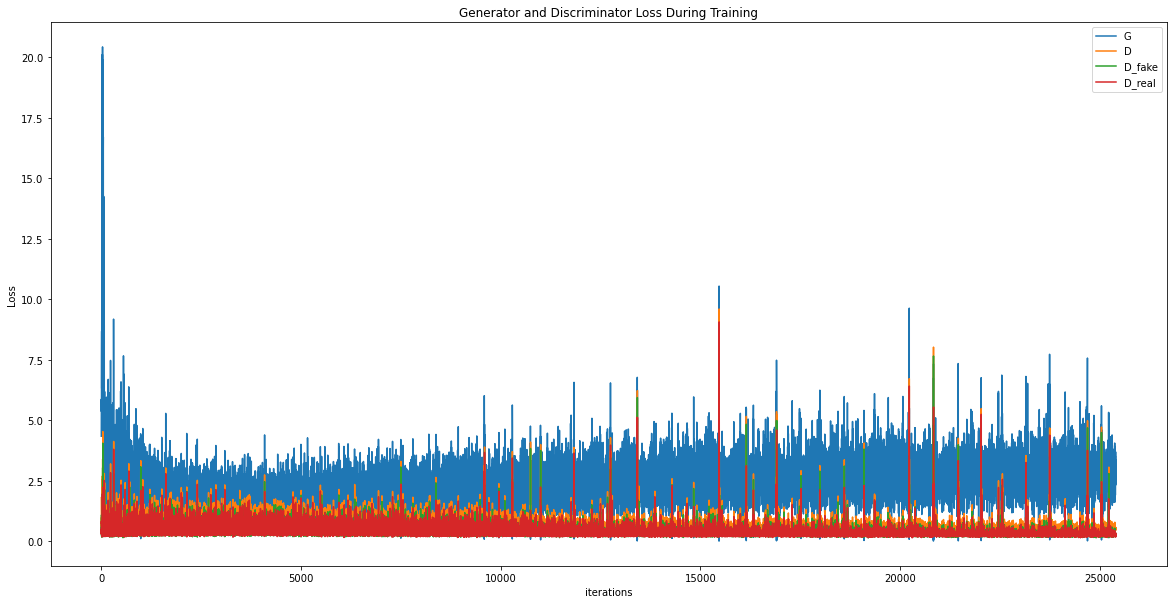

In [16]:
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(D_fake_losses,label="D_fake")
plt.plot(D_real_losses,label="D_real")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(path,"generator_discriminator_losses.png"))

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Discriminator Accuracy During Training")
plt.plot(D_x_acc,label="D_acc")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(path,"discriminator_accuracy.png"))

In [15]:
from scipy import stats


d_losses_mode = stats.mode(D_losses)
d_fake_losses_mode = stats.mode(D_fake_losses)
d_real_losses_mode = stats.mode(D_real_losses)
g_losses_mode = stats.mode(G_losses)

f = open(os.path.join(path,"overall_stats.txt"), "a")
f.write("Dataset: \t" + dataset_name +"\n")
f.write("Dataset size: \t" + str(dataset_size) +"\n")
f.write("D_losses mean: \t" + str(np.mean(D_losses)) +"\n")
f.write("D_losses mode: \t" + str(d_losses_mode.mode[0]) +"\n")
f.write("D_fake_losses mean: \t" + str(np.mean(D_fake_losses)) +"\n")
f.write("D_fake_losses mode: \t" + str(d_fake_losses_mode.mode[0]) +"\n")
f.write("D_real_losses mean: \t" + str(np.mean(D_real_losses)) +"\n")
f.write("D_real_losses mode: \t" + str(d_real_losses_mode.mode[0]) +"\n")
f.write("G_losses mean: \t" + str(np.mean(G_losses)) +"\n")
f.write("G_losses mode: \t" + str(g_losses_mode.mode[0]) +"\n")
f.write("Discriminator accuracy mean \t" + str(np.mean(D_x_acc)))

f.close()

ModuleNotFoundError: No module named 'scipy'

In [ ]:
# Animation of generations over time

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig(os.path.join(path,"real_vs_fake_images.png"))

In [ ]:
from torchvision.utils import save_image

gen_img_dir = os.path.join(path, "generated_images")
if not os.path.exists(gen_img_dir):
    os.mkdir(gen_img_dir)
im_batch_size = 64
n_images=100
for i_batch in range(0, n_images, im_batch_size):
    gen_images = netG(fixed_noise)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join(gen_img_dir, f'image_{i_batch+i_image:05d}.png'))

In [ ]:
from zipfile import ZipFile
from os.path import basename


zip_file =  home_dir + "outputs/" + results_dir + ".zip"
with ZipFile(zip_file, 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk(path):
       for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))